Calibration (2021-2022): μ = 0.052, σ = 0.451


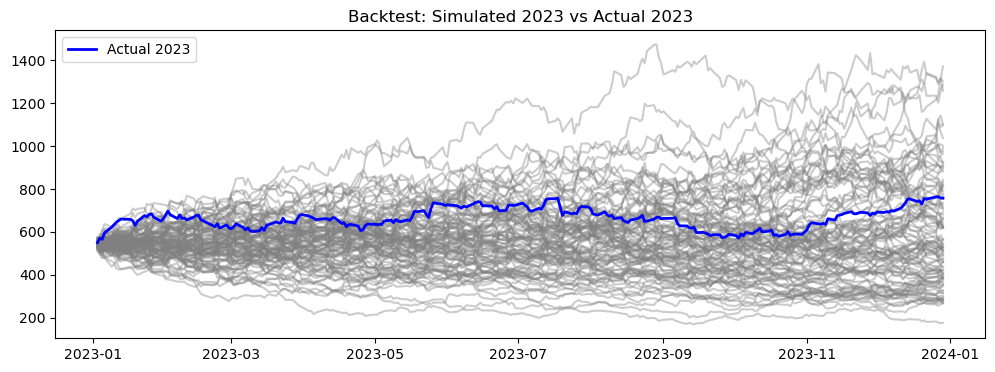

Backtest MAE: 185, RMSE: 326
Forecast calibration (2023): μ = 0.324, σ = 0.310
Forecasted mean price (end-2024): 1058
90% CI: [608, 1667]


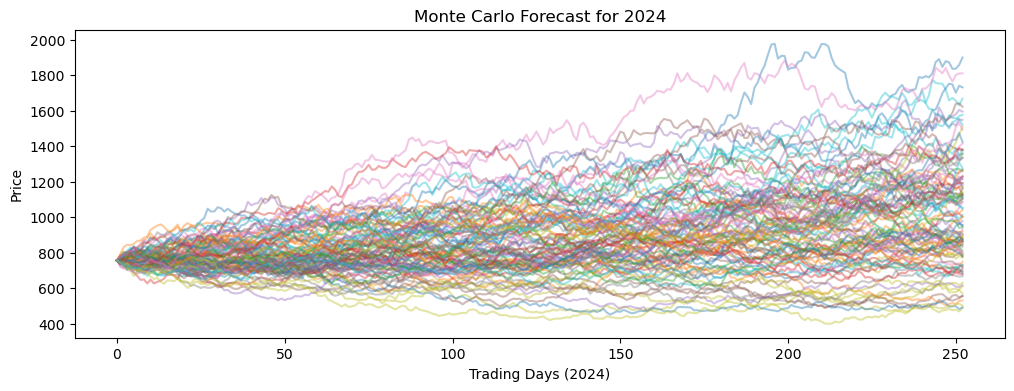

Monte Carlo Call Price: 85.24
Black–Scholes Call Price: 85.09
Difference MC vs BS: 0.14 (0.17%)
Base MC Call Price: 85.41
Delta: 0.4890
Gamma: -0.013720
Vega:  257.74
Rho:   343.63
Theta: -398.57


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.stats import norm

#Using Stooq because Yahoo charges/limits on the number of API calls
ticker = "ASML.US"   
data = web.DataReader(ticker, "stooq")
data = data.sort_index()   # chronological order
prices = data['Close']

#Calibration (μ, σ)
def annualized_params(price_series):
    returns = np.log(price_series / price_series.shift(1)).dropna()
    mu = returns.mean() * 252
    sigma = returns.std() * np.sqrt(252)
    return mu, sigma

#Calibration window
prices_calib = prices.loc["2021-01-01":"2022-12-31"]
mu_cal, sigma_cal = annualized_params(prices_calib)
print(f"Calibration (2021-2022): μ = {mu_cal:.3f}, σ = {sigma_cal:.3f}")

#Backtest 2023 
prices_2023 = prices.loc["2023-01-01":"2023-12-31"]
S0_backtest = prices_calib.iloc[-1]
days_backtest = len(prices_2023)
N = 2000
dt = 1/252
paths_backtest = np.zeros((days_backtest+1, N))
paths_backtest[0] = S0_backtest

np.random.seed(42)
for t in range(1, days_backtest+1):
    Z = np.random.standard_normal(N)
    paths_backtest[t] = paths_backtest[t-1] * np.exp((mu_cal - 0.5*sigma_cal**2)*dt + sigma_cal*np.sqrt(dt)*Z)

#Backtest
plt.figure(figsize=(12,4))
plt.plot(prices_2023.index, paths_backtest[1:, :100], color='gray', alpha=0.4)
plt.plot(prices_2023.index, prices_2023.values, 'b', linewidth=2, label='Actual 2023')
plt.title("Backtest: Simulated 2023 vs Actual 2023")
plt.legend()
plt.show()

#Error Metrics
sim_mean = paths_backtest[-1].mean()
actual_end = prices_2023.iloc[-1]
mae = abs(sim_mean - actual_end)
rmse = np.sqrt(np.mean((paths_backtest[-1] - actual_end)**2))
print(f"Backtest MAE: {mae:.0f}, RMSE: {rmse:.0f}")

#Forecast 2024
mu_forecast, sigma_forecast = annualized_params(prices_2023)
print(f"Forecast calibration (2023): μ = {mu_forecast:.3f}, σ = {sigma_forecast:.3f}")

S0_forecast = prices_2023.iloc[-1]
days_forecast = 252
paths_forecast = np.zeros((days_forecast+1, N))
paths_forecast[0] = S0_forecast

np.random.seed(2024)
for t in range(1, days_forecast+1):
    Z = np.random.standard_normal(N)
    paths_forecast[t] = paths_forecast[t-1] * np.exp((mu_forecast - 0.5*sigma_forecast**2)*dt + sigma_forecast*np.sqrt(dt)*Z)

#Forecast results
forecast_terminal = paths_forecast[-1]
mean_forecast = forecast_terminal.mean()
p05, p95 = np.percentile(forecast_terminal, [5,95])
print(f"Forecasted mean price (end-2024): {mean_forecast:.0f}")
print(f"90% CI: [{p05:.0f}, {p95:.0f}]")

#Plotting Forecast
plt.figure(figsize=(12,4))
plt.plot(paths_forecast[:, :100], alpha=0.4)
plt.title("Monte Carlo Forecast for 2024")
plt.xlabel("Trading Days (2024)")
plt.ylabel("Price")
plt.show()

#Option Pricing
r = 0.03              #risk-free rate
T = 1.0               #maturity (1 year)
K = round(S0_forecast * 1.05, -2)  #strike ≈ 5% above spot
N = 100_000
dt = 1/252
steps = int(T/dt)
sigma_rn = sigma_forecast
S0_rn = S0_forecast

#Monte Carlo Risk-neutral
np.random.seed(123)
paths_rn = np.zeros((steps + 1, N))
paths_rn[0] = S0_rn
for t in range(1, steps + 1):
    Z = np.random.standard_normal(N)
    paths_rn[t] = paths_rn[t-1] * np.exp((r - 0.5 * sigma_rn**2) * dt + sigma_rn * np.sqrt(dt) * Z)

ST = paths_rn[-1]
payoffs = np.maximum(ST - K, 0)
call_price_mc = np.exp(-r*T) * payoffs.mean()
print(f"Monte Carlo Call Price: {call_price_mc:.2f}")

#Black–Scholes
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

call_price_bs = bs_call_price(S0_rn, K, T, r, sigma_rn)
print(f"Black–Scholes Call Price: {call_price_bs:.2f}")

#Difference
diff = abs(call_price_mc - call_price_bs)
print(f"Difference MC vs BS: {diff:.2f} ({100*diff/call_price_bs:.2f}%)")

#Greeks via finite differences
def mc_call_price(S0, K, T, r, sigma, N=50_000, steps=252):
    """Monte Carlo European Call under risk-neutral measure"""
    dt = T / steps
    Z = np.random.standard_normal((steps, N))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=0)
    ST = S0 * np.exp(log_paths[-1])
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * payoff.mean()

#Base case
base_price = mc_call_price(S0_rn, K, T, r, sigma_rn)
print(f"Base MC Call Price: {base_price:.2f}")

#Greeks
eps_S = 1e-2 * S0_rn
eps_sigma = 0.01
eps_r = 0.01
eps_T = 1/252  # one day

Delta = (mc_call_price(S0_rn+eps_S, K, T, r, sigma_rn) -
         mc_call_price(S0_rn-eps_S, K, T, r, sigma_rn)) / (2*eps_S)

Gamma = (mc_call_price(S0_rn+eps_S, K, T, r, sigma_rn) -
         2*base_price +
         mc_call_price(S0_rn-eps_S, K, T, r, sigma_rn)) / (eps_S**2)

Vega = (mc_call_price(S0_rn, K, T, r, sigma_rn+eps_sigma) -
        mc_call_price(S0_rn, K, T, r, sigma_rn-eps_sigma)) / (2*eps_sigma)

Rho = (mc_call_price(S0_rn, K, T, r+eps_r, sigma_rn) -
       mc_call_price(S0_rn, K, T, r-eps_r, sigma_rn)) / (2*eps_r)

Theta = (mc_call_price(S0_rn, K, T-eps_T, r, sigma_rn) - base_price) / eps_T

print(f"Delta: {Delta:.4f}")
print(f"Gamma: {Gamma:.6f}")
print(f"Vega:  {Vega:.2f}")
print(f"Rho:   {Rho:.2f}")
print(f"Theta: {Theta:.2f}")



In [7]:

log_returns = np.log(prices / prices.shift(1)).dropna()
mu_cal = log_returns.mean() * 252
sigma_cal = log_returns.std() * np.sqrt(252)

#Actual drift (Jensen correction)
mu_actual_cal = mu_cal + 0.5 * sigma_cal**2
print(f"Actual drift (2021–22): {mu_actual_cal:.3%}")

mu_actual_fore = mu_forecast + 0.5 * sigma_forecast**2
print(f"Actual drift (from 2023): {mu_actual_fore:.3%}")

print(f"Risk-free rate r: {r:.2%}")

#Realized CAGR for 2023
S0 = prices_2023.iloc[0]
S1 = prices_2023.iloc[-1]
days = len(prices_2023)

cagr_2023 = (S1 / S0)**(252/days) - 1
print(f"Realized annualized return 2023 (CAGR): {cagr_2023:.3%}")


Actual drift (2021–22): 23.055%
Actual drift (from 2023): 37.210%
Risk-free rate r: 3.00%
Realized annualized return 2023 (CAGR): 38.083%
